In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Problem - 1: Perform a classification task with knn from scratch

In [4]:
# Import pandas to read the CSV file
import pandas as pd

# Load the diabetes dataset from the specified path
file_path = '/content/drive/My Drive/Dataset/diabetes_.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Check for missing values
missing_info = data.isnull().sum() / len(data) * 100

# Handle missing values
for column in data.columns:
    if missing_info[column] > 10:  # If more than 10% missing, fill with mean
        data[column].fillna(data[column].mean(), inplace=True)
    else:  # If less than 10% missing, drop the rows
        data.dropna(subset=[column], inplace=True)

print("Data after processing:\n", data.head())
print("\nMissing values after processing:\n", data.isnull().sum())

Data after processing:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values after processing:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outc

In [6]:
# Separate features (X) and target variable (y)
X = data.drop(columns=['Outcome']).values  # Features
y = data['Outcome'].values  # Target variable

# Train-test split function (30% test, 70% train)
import numpy as np

def train_test_split_scratch(X, y, test_size=0.3, random_seed=42):
    np.random.seed(random_seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)  # Shuffle the data
    test_split_size = int(len(X) * test_size)
    test_indices = indices[:test_split_size]
    train_indices = indices[test_split_size:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3)

# Verify the shape of the split data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (538, 8)
Shape of X_test: (230, 8)


In [7]:
# Euclidean distance function
def euclidean_distance(point1, point2):
    if point1.shape != point2.shape:
        raise ValueError("Points must have the same dimensions")
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Predict the class label for a single query
def knn_predict_single(query, X_train, y_train, k=3):
    distances = [euclidean_distance(query, x) for x in X_train]
    sorted_indices = np.argsort(distances)
    nearest_indices = sorted_indices[:k]
    nearest_labels = y_train[nearest_indices]
    prediction = np.bincount(nearest_labels).argmax()  # Majority vote
    return prediction

# Predict class labels for all test samples
def knn_predict(X_test, X_train, y_train, k=3):
    predictions = [knn_predict_single(x, X_train, y_train, k) for x in X_test]
    return np.array(predictions)

# Example prediction on a small subset
X_test_sample = X_test[:5]
y_test_sample = y_test[:5]
predictions = knn_predict(X_test_sample, X_train, y_train, k=3)
print("Predictions:", predictions)
print("Actual labels:", y_test_sample)

Predictions: [0 1 0 1 1]
Actual labels: [0 0 0 0 0]


In [8]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

# Calculate accuracy for the predictions
accuracy = compute_accuracy(y_test_sample, predictions)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 40.00%


Problem - 2 - Experimentation

In [9]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate KNN on scaled data
predictions_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)
accuracy_scaled = compute_accuracy(y_test, predictions_scaled)
print(f"Accuracy on scaled data: {accuracy_scaled:.2f}%")

Accuracy on scaled data: 70.87%


In [10]:
# Evaluate KNN on non-scaled data
predictions_non_scaled = knn_predict(X_test, X_train, y_train, k=3)
accuracy_non_scaled = compute_accuracy(y_test, predictions_non_scaled)

# Compare accuracies
print(f"Accuracy on non-scaled data: {accuracy_non_scaled:.2f}%")
print(f"Accuracy on scaled data: {accuracy_scaled:.2f}%")

Accuracy on non-scaled data: 67.39%
Accuracy on scaled data: 70.87%


Discussion:

Scaling: Scaling affects KNN because it makes sure that all features contribute equally to the distance metric (Euclidean distance). Without scaling, features with larger ranges dominate the distance calculation, leading to biased predictions.

Accuracy: If your features are on vastly different scales, scaling might significantly improve accuracy by reducing the bias introduced by large-valued features.

Problem - 3 - Experimentation with k

In [11]:
import time

def experiment_knn_k_values(X_train, y_train, X_test, y_test, k_values):
    accuracies = {}
    times = {}

    for k in k_values:
        start_time = time.time()  # Start the timer
        predictions = knn_predict(X_test, X_train, y_train, k)
        end_time = time.time()  # Stop the timer
        accuracy = compute_accuracy(y_test, predictions)

        accuracies[k] = accuracy
        times[k] = end_time - start_time  # Record time taken for prediction
        print(f"Accuracy for k={k}: {accuracy:.2f}% | Time taken: {times[k]:.4f} seconds")

    return accuracies, times

# Experiment with original (non-scaled) data
print("Results for Non-Scaled Data:")
accuracies_non_scaled, times_non_scaled = experiment_knn_k_values(X_train, y_train, X_test, y_test, range(1, 16))

# Add a separator for clarity
print("\n" + "-"*50 + "\n")

# Experiment with scaled data
print("Results for Scaled Data:")
accuracies_scaled, times_scaled = experiment_knn_k_values(X_train_scaled, y_train, X_test_scaled, y_test, range(1, 16))

Results for Non-Scaled Data:
Accuracy for k=1: 68.70% | Time taken: 1.5377 seconds
Accuracy for k=2: 72.61% | Time taken: 1.4692 seconds
Accuracy for k=3: 67.39% | Time taken: 1.2439 seconds
Accuracy for k=4: 72.17% | Time taken: 0.8445 seconds
Accuracy for k=5: 68.70% | Time taken: 0.8425 seconds
Accuracy for k=6: 70.00% | Time taken: 0.8273 seconds
Accuracy for k=7: 69.13% | Time taken: 0.8383 seconds
Accuracy for k=8: 71.30% | Time taken: 0.8302 seconds
Accuracy for k=9: 70.00% | Time taken: 0.8432 seconds
Accuracy for k=10: 71.74% | Time taken: 0.8421 seconds
Accuracy for k=11: 73.04% | Time taken: 0.8231 seconds
Accuracy for k=12: 73.91% | Time taken: 0.8530 seconds
Accuracy for k=13: 74.35% | Time taken: 0.8450 seconds
Accuracy for k=14: 72.61% | Time taken: 0.8439 seconds
Accuracy for k=15: 73.91% | Time taken: 1.1451 seconds

--------------------------------------------------

Results for Scaled Data:
Accuracy for k=1: 63.48% | Time taken: 1.4787 seconds
Accuracy for k=2: 66.09

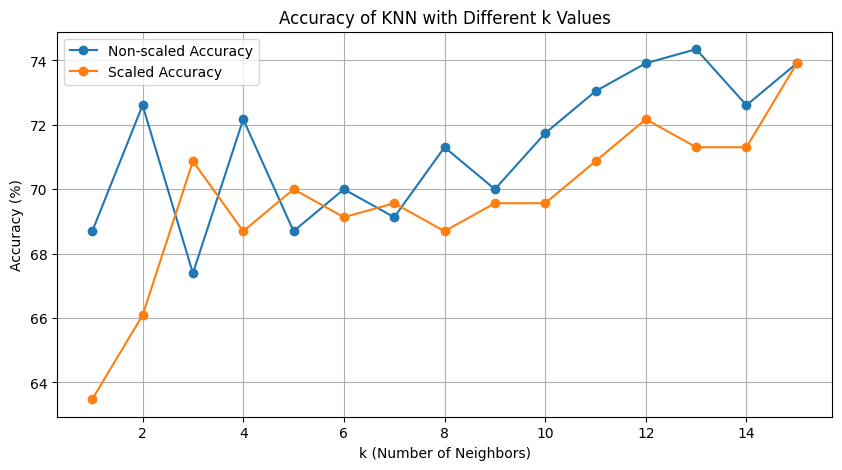

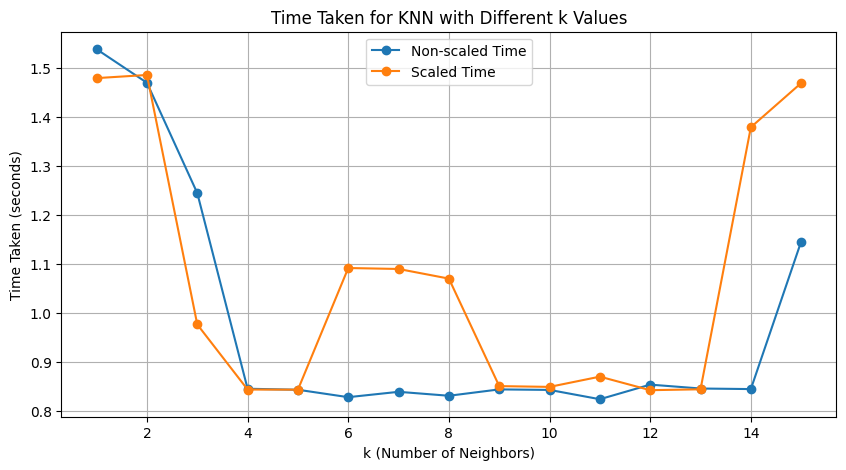

In [14]:
import matplotlib.pyplot as plt

k_values = range(1, 16)

# Plot k vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(k_values, list(accuracies_non_scaled.values()), label='Non-scaled Accuracy', marker='o')
plt.plot(k_values, list(accuracies_scaled.values()), label='Scaled Accuracy', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of KNN with Different k Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot k vs Time Taken
plt.figure(figsize=(10, 5))
plt.plot(k_values, list(times_non_scaled.values()), label='Non-scaled Time', marker='o')
plt.plot(k_values, list(times_scaled.values()), label='Scaled Time', marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken for KNN with Different k Values')
plt.legend()
plt.grid(True)
plt.show()

Analyze and Discuss:

Effect of k: The choice of k affects the model’s bias-variance tradeoff. Small k values can lead to overfitting, while large k values can make the model too generalized.

Accuracy vs Time: As k increases, accuracy may improve (up to a point), but the computation time will also increase due to the additional distance calculations.

Optimal k: Based on the accuracy plot, you can determine the best k value by finding the point where accuracy stabilizes or peaks. Similarly, consider the time taken to make predictions for choosing an optimal k.

Problem 4: Additional Questions (Optional)

Challenges of KNN for Large Datasets and High-Dimensional Data:

KNN becomes computationally expensive for large datasets because it requires calculating the distance between the test point and every point in the training set, leading to high time complexity (O(n) for each prediction). This can make the algorithm impractical for large-scale datasets.

In high-dimensional data (curse of dimensionality), the distance between points increases, making it harder to find meaningful neighbors. This degrades the performance of KNN.

Strategies to Improve Efficiency:

Approximate Nearest Neighbors (ANN): Instead of calculating the exact nearest neighbors, algorithms like KD-Trees or Ball Trees can approximate the nearest neighbors faster, especially in lower dimensions.

Dimensionality Reduction: Techniques like PCA (Principal Component Analysis) or t-SNE can reduce the number of features, making the distance calculation more meaningful and faster.

Data Sampling: In case of large datasets, using a subset of the data for training can speed up the computations.